<a href="https://colab.research.google.com/github/AllanKDeveloper/dio-evaluation-classification-models/blob/main/matrix_confusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
from typing import Tuple, Dict

%load_ext tensorboard

logdir = 'log'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reshape and normalize the image data
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the classes
classes = [0,1,2,3,4,5,6,7,8,9]

# Create the sequential model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Set up TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Select only 150 samples for training
train_images_subset = train_images[:150]
train_labels_subset = train_labels[:150]

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the subset
model.fit(x=train_images_subset,
          y=train_labels_subset,
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - accuracy: 0.1228 - loss: 2.2905 - val_accuracy: 0.2986 - val_loss: 2.2414
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 611ms/step - accuracy: 0.3982 - loss: 2.1693 - val_accuracy: 0.3782 - val_loss: 2.1343
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 987ms/step - accuracy: 0.4861 - loss: 1.9861 - val_accuracy: 0.4386 - val_loss: 1.9061
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 603ms/step - accuracy: 0.6228 - loss: 1.6243 - val_accuracy: 0.5445 - val_loss: 1.5878
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - accuracy: 0.6970 - loss: 1.1890 - val_accuracy: 0.6432 - val_loss: 1.2418


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


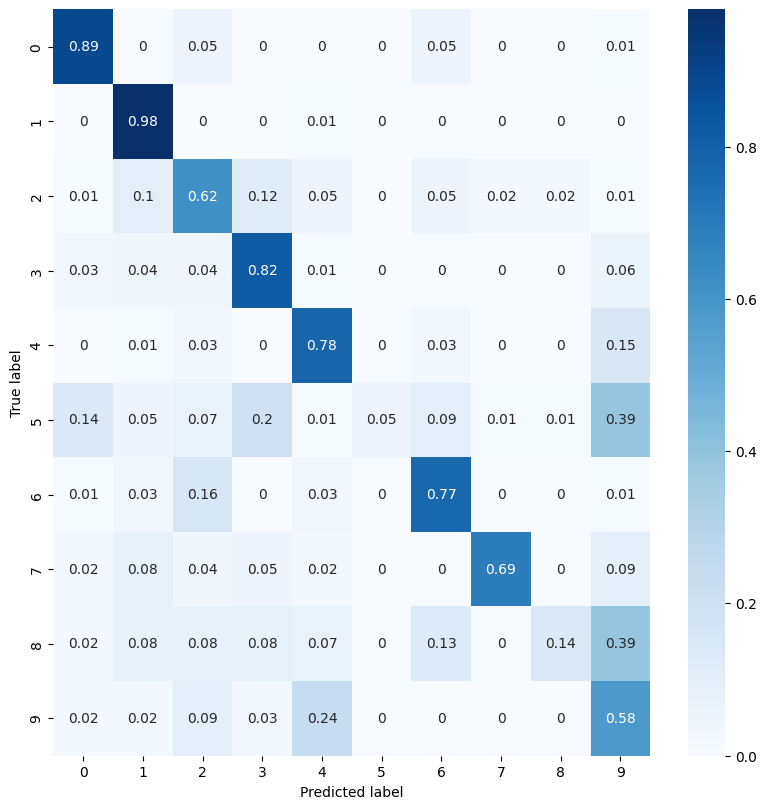

In [27]:
# Get predictions
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=1)

# Define classes
classes = [0,1,2,3,4,5,6,7,8,9]

# Create confusion matrix and normalize it
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

# Convert to DataFrame for better visualization
con_mat_df = pd.DataFrame(con_mat_norm,
                          index=classes,
                          columns=classes)

# Create heatmap visualization
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Absolute values of the confusion matrix by class:
       TP      TN      FP     FN
0   869.0  8788.0   232.0  111.0
1  1113.0  8468.0   397.0   22.0
2   644.0  8417.0   551.0  388.0
3   824.0  8527.0   463.0  186.0
4   763.0  8575.0   443.0  219.0
5    48.0  9100.0     8.0  844.0
6   736.0  8692.0   350.0  222.0
7   713.0  8937.0    35.0  315.0
8   133.0  9000.0    26.0  841.0
9   589.0  7928.0  1063.0  420.0


Calculated metrics by class:
   Accuracy  Sensitivity (Recall)  Specificity  Precision  F1-Score
0     0.966                 0.887        0.974      0.789     0.835
1     0.958                 0.981        0.955      0.737     0.842
2     0.906                 0.624        0.939      0.539     0.578
3     0.935                 0.816        0.948      0.640     0.717
4     0.934                 0.777        0.951      0.633     0.697
5     0.915                 0.054        0.999      0.857     0.101
6     0.943                 0.768        0.961      0.678     0.720
7     0.965 

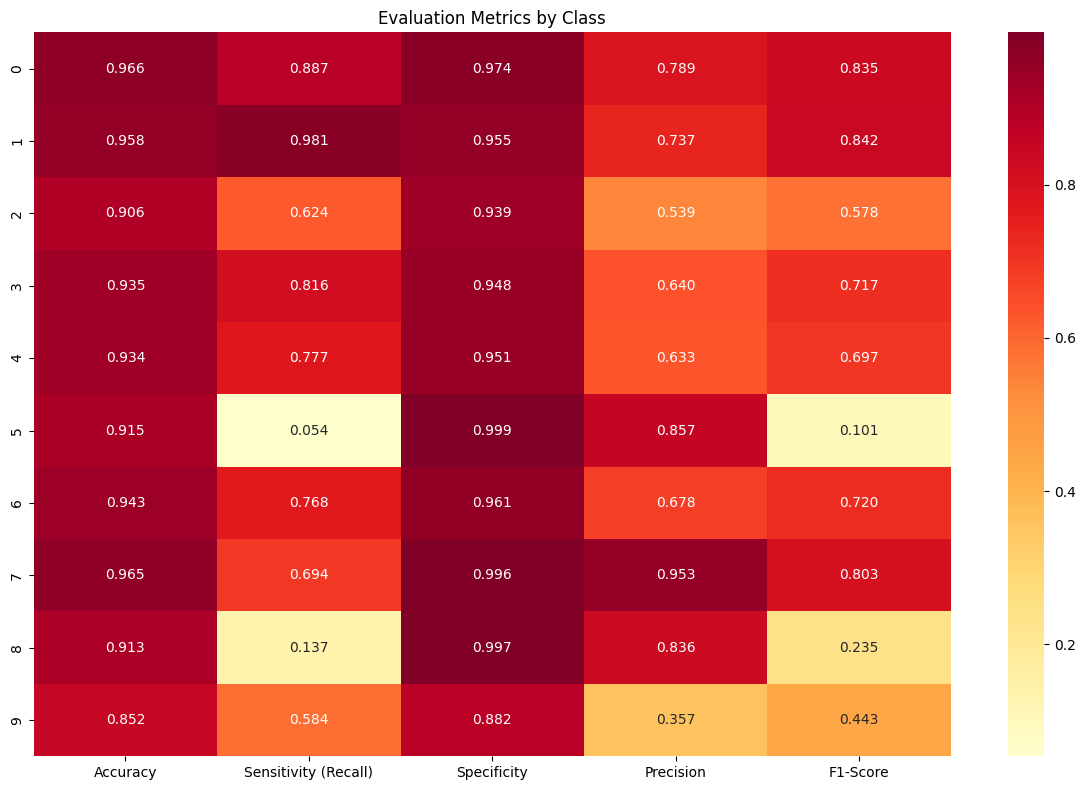

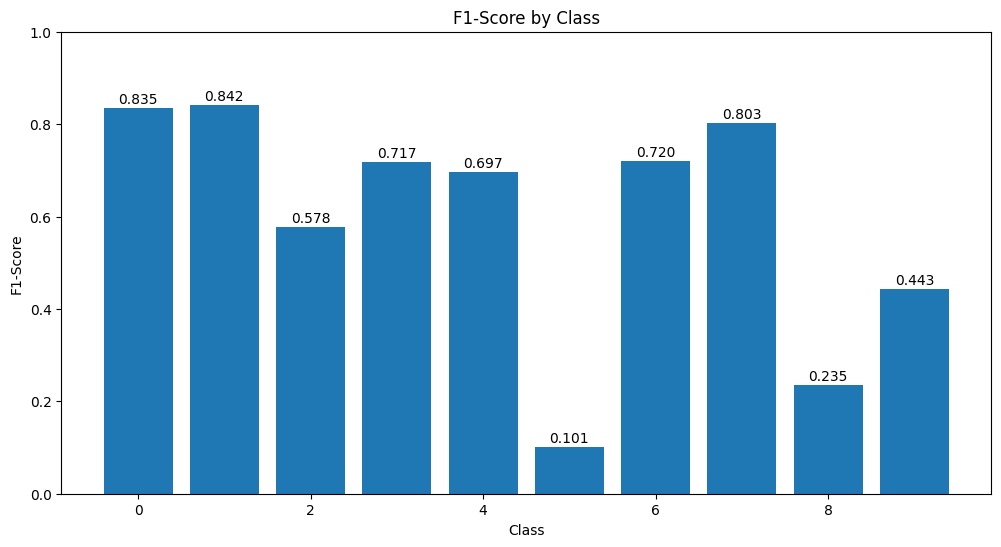

In [34]:
# Using the pre-calculated confusion matrix (con_mat)
metrics_per_class = {}

# Calculating metrics for each class using the non-normalized matrix
for i in range(len(classes)):
    # True Positives (TP) - diagonal of the matrix
    TP = con_mat[i, i]

    # False Positives (FP) - sum of the column minus TP
    FP = np.sum(con_mat[:, i]) - TP

    # False Negatives (FN) - sum of the row minus TP
    FN = np.sum(con_mat[i, :]) - TP

    # True Negatives (TN) - sum of all elements minus TP, FN, and FP
    TN = np.sum(con_mat) - TP - FN - FP

    # Calculating the metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    metrics_per_class[classes[i]] = {
        'TP': int(TP),
        'TN': int(TN),
        'FP': int(FP),
        'FN': int(FN),
        'Accuracy': round(accuracy, 3),
        'Sensitivity (Recall)': round(sensitivity, 3),
        'Specificity': round(specificity, 3),
        'Precision': round(precision, 3),
        'F1-Score': round(f1_score, 3)
    }

# Create DataFrame with the metrics
df_metrics = pd.DataFrame(metrics_per_class).T

# Display absolute values (TP, TN, FP, FN)
print("Absolute values of the confusion matrix by class:")
absolute_values = df_metrics[['TP', 'TN', 'FP', 'FN']]
print(absolute_values)
print("\n")

# Display calculated metrics
print("Calculated metrics by class:")
calculated_metrics = df_metrics[['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'Precision', 'F1-Score']]
print(calculated_metrics)
print("\n")

# Calculate and display averages
averages = calculated_metrics.mean()
print("Average model metrics:")
for metric, value in averages.items():
    print(f"{metric}: {value:.3f}")

# Visualize the main metrics in a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(calculated_metrics, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Evaluation Metrics by Class')
plt.tight_layout()
plt.show()

# Create a bar visualization to compare F1-Score across classes
plt.figure(figsize=(12, 6))
plt.bar(classes, df_metrics['F1-Score'])
plt.title('F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(df_metrics['F1-Score']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.show()